In [0]:
import numpy as np 
import pandas as pd 
from sklearn import datasets, ensemble, model_selection
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns

In [0]:
%matplotlib inline

In [0]:
data=datasets.load_breast_cancer()

In [4]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [0]:
x,y=data.data,data.target

In [0]:
df=pd.DataFrame(data=data.data,columns=data.feature_names)
df['Target']=y

In [8]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [0]:
pp.ProfileReport(df)

Number of variables,31
Number of observations,569
Total Missing (%),0.0%
Total size in memory,137.9 KiB
Average record size in memory,248.1 B
Numeric,20
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,10


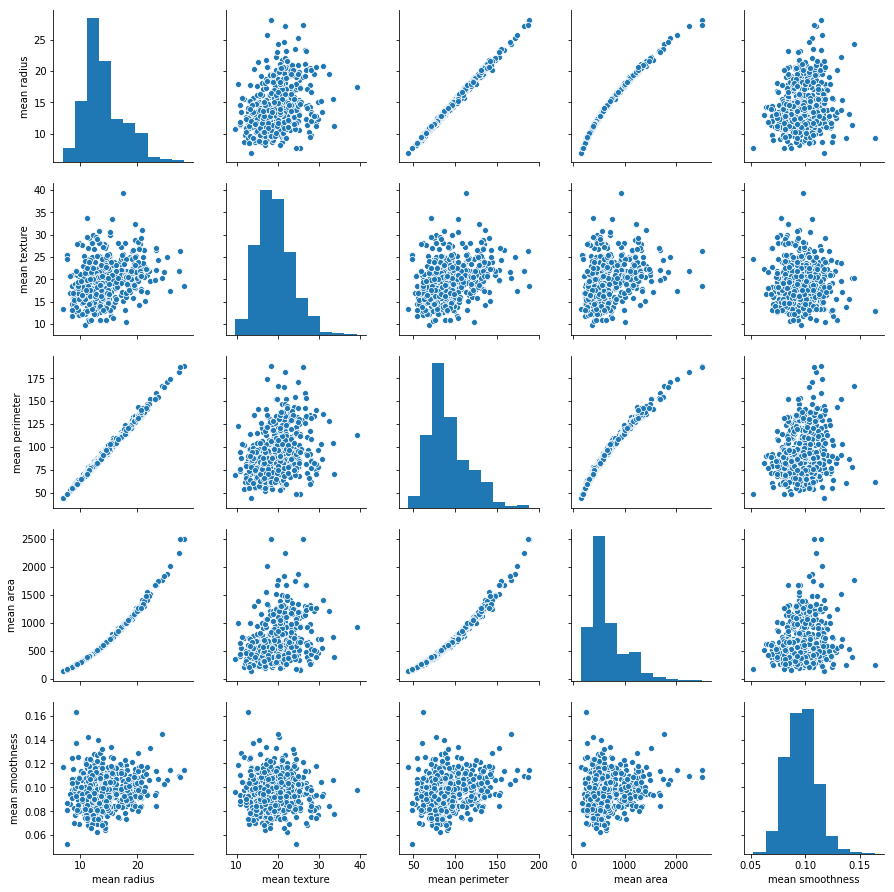

In [16]:
cols=list(df.columns[:5])
sns.pairplot(df[cols])


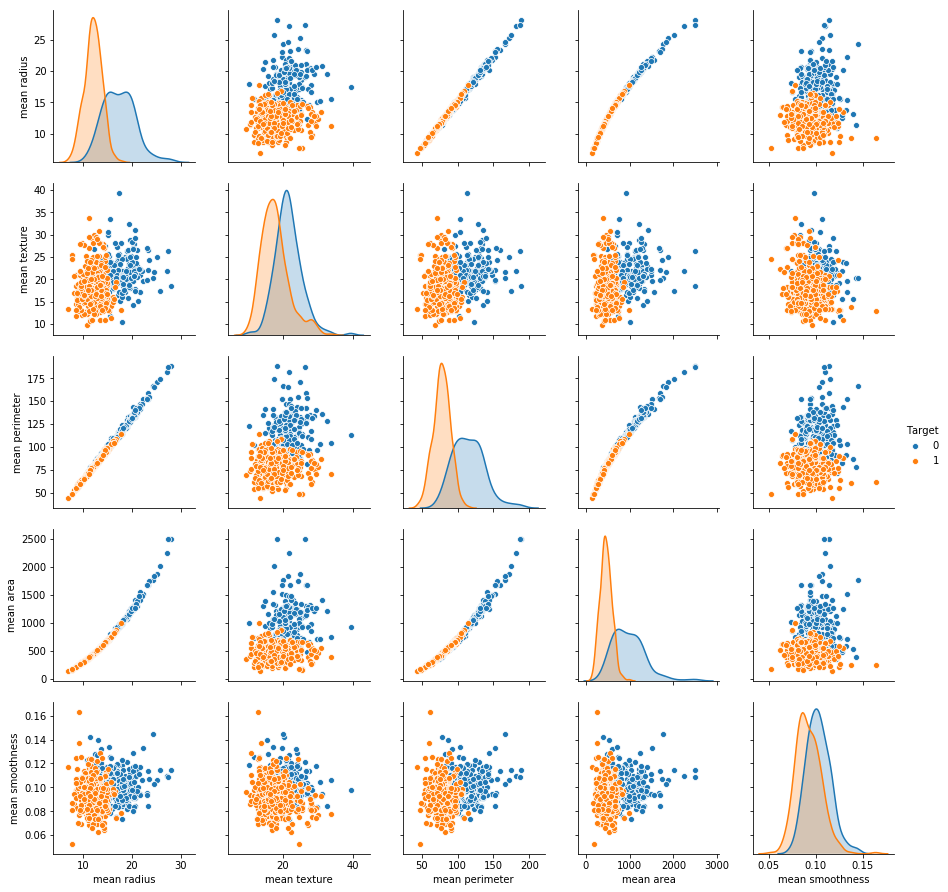

In [17]:
sns.pairplot(df,hue='Target',vars=df.columns[:5])

In [0]:
xtr,xval,ytr,yval=model_selection.train_test_split(x,y,test_size=.3,random_state=11)

In [0]:
model=ensemble.RandomForestClassifier(n_estimators=10,oob_score=True,random_state=25)

In [0]:
model.fit(xtr,ytr)
model.score(xtr,ytr)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.9974874371859297

In [0]:
model.oob_score_

0.9246231155778895

In [0]:
model.score(xval,yval)

0.9532163742690059

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
pred=model.predict(xval)
confusion_matrix(yval,pred)

array([[ 55,   6],
       [  2, 108]])

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

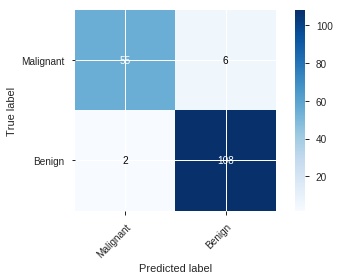

In [0]:
plot_confusion_matrix(yval,pred,['Malignant','Benign'])

In [0]:
model.oob_score_

0.9246231155778895

What would happen if we increase the number of trees?

In [0]:

model=ensemble.RandomForestClassifier(n_estimators=30,oob_score=True,random_state=25)
model.fit(xtr,ytr)
model.score(xtr,ytr),model.oob_score_,model.score(xval,yval)

(1.0, 0.9547738693467337, 0.9590643274853801)

What would happen if we set a value for max_features? By default it is set to 'auto' which uses square root of total number of features.

In [0]:
model=ensemble.RandomForestClassifier(n_estimators=10,max_features=4,oob_score=True,random_state=25)
model.fit(xtr,ytr)
model.score(xtr,ytr),model.oob_score_,model.score(xval,yval)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


(0.9949748743718593, 0.9246231155778895, 0.9707602339181286)

Let's change other parameters in the model. This time we set max_depth to 3. If this value is not set the tree grows until it reaches the minimum number of data points (min_sample_split) in every leaf.

In [0]:
model=ensemble.RandomForestClassifier(n_estimators=10,max_depth=3,oob_score=True,random_state=25)
model.fit(xtr,ytr)
model.score(xtr,ytr),model.oob_score_,model.score(xval,yval)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


(0.9773869346733668, 0.9296482412060302, 0.935672514619883)

What if we use max_depth of 3 and more trees?

In [0]:
model=ensemble.RandomForestClassifier(n_estimators=50,max_depth=3,oob_score=True,random_state=25)
model.fit(xtr,ytr)
model.score(xtr,ytr),model.oob_score_,model.score(xval,yval)

(0.9748743718592965, 0.9522613065326633, 0.9532163742690059)

# Hyperparameter Optimization
As you can see performance of the model relies on the values of the model parameters. How do we know what values we should choose? These parameters that define the model are called hyperparameter. To find the best values we need to perform hyperparameter optimization. There are various methods for hyperparameter optimization. What we are using here is called grid search. Basically, we choose a few values for some of the parameters and try every combination. Obviously, this method is not practicall if we have many hyperparameters and a wide range of values for each. 

In [0]:
params={'max_features':[4,5,6,7],'max_depth':[2,3,4,5],'n_estimators':[20,50,100]}
grid_search=model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=21,oob_score=True),
                                         param_grid=params,
                                         cv=4)

So, we created a dictionary containing the parameters we want to set and the values we want to try. We passed the model we want to train, as well as the parameter values we want to try and cv! What is cv? Cross Validation.
Cross Validation split the data into n folds. Then, the model is trained using n-1 folds and then tested (validated) on the fold that we haven't used. We can do this n times (one for each fold) and take the average of the validation score. This is a useful method to make sure that a good score wasn't just by chance. 
We are using cv=5 here which means we are splitting the data into 5 sets.


In [0]:
# depends on the number of trials this might take some time to run.
grid_search.fit(xtr,ytr)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=True, random_state=21,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'m

In [0]:
grid_search.best_params_

{'max_depth': 4, 'max_features': 7, 'n_estimators': 100}

In [0]:
model=grid_search.best_estimator_
model.score(xtr,ytr),model.oob_score_,model.score(xval,yval)

(0.992462311557789, 0.9547738693467337, 0.9590643274853801)

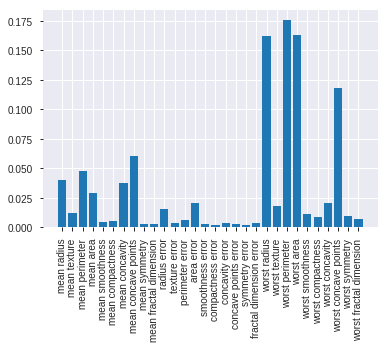

In [0]:
plt.bar(data.feature_names,model.feature_importances_);
plt.xticks(rotation=90);

We managed to slightly improve the model. Is there room for more improvement? Certainly. We could do some feature engineering, which sometimes significantly improve the model. As we saw in the plots some of the features highly correlate. That means all the information we need, we can get from one of them. Having both of them in the dataset is unnecessary and most of the time even lowers the model accuracy. Also, Sometimes removing features that have low importance (according to the plot above) can also improve the model.